# AI-driven morphoclimatic regional frequency modelling of sub-daily rainfall-extremes
**Authors**: Chiara Angileri, Niccolò Marzi, Shola Oshodi

# 0. Importing libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt


# 1. Load and insepct the dataset

In [2]:
df = pd.read_csv('data/AMS_descritt_noSM_meltD_adim.csv', sep=',', encoding='utf-8')
df.drop(df.columns[[0]], axis=1, inplace=True)
df.head()

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,X,Y,duration[h],AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,1.221239,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,0.778761,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
2,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.219018,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
3,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,0.979995,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
4,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.153287,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679


## 1.1. Preprocess the dataset
spiegazione di come vengono taggruppate i vari dati

In [3]:
grouped_AMS = df.groupby(['ID', 'duration[h]'])['AMS'].apply(list).reset_index()
grouped_IdD = df.groupby(['ID', 'duration[h]'])['mean_IdD'].unique().apply(lambda x:  x[0] if len(x) > 0 else None).reset_index()

pivoted_AMS = grouped_AMS.pivot(index='ID', columns='duration[h]', values='AMS')
pivoted_IdD = grouped_IdD.pivot(index='ID', columns='duration[h]', values='mean_IdD')

pivoted_AMS.columns = [f'AMS_{col}' for col in pivoted_AMS.columns]
pivoted_IdD.columns = [f'IdD_{col}' for col in pivoted_IdD.columns]
 
pivoted_AMS.reset_index(inplace=True)
pivoted_IdD.reset_index(inplace=True)

df = pd.merge(df, pivoted_AMS, on='ID')
df = pd.merge(df, pivoted_IdD, on='ID')

df.head()

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,AMS_1,AMS_3,AMS_6,AMS_12,AMS_24,IdD_1,IdD_3,IdD_6,IdD_12,IdD_24
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,...,"[1.2212389380530972, 0.7787610619469026]","[1.1067961165048543, 0.8932038834951457, 1.184...","[1.136231884057971, 0.9391304347826088, 1.1130...","[1.2430555555555556, 0.9861111111111112, 1.041...","[1.5184490306441525, 0.9455909943714822, 0.855...",28.25,51.5,86.25,144.0,199.875
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,...,"[1.2212389380530972, 0.7787610619469026]","[1.1067961165048543, 0.8932038834951457, 1.184...","[1.136231884057971, 0.9391304347826088, 1.1130...","[1.2430555555555556, 0.9861111111111112, 1.041...","[1.5184490306441525, 0.9455909943714822, 0.855...",28.25,51.5,86.25,144.0,199.875
2,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,...,"[1.2212389380530972, 0.7787610619469026]","[1.1067961165048543, 0.8932038834951457, 1.184...","[1.136231884057971, 0.9391304347826088, 1.1130...","[1.2430555555555556, 0.9861111111111112, 1.041...","[1.5184490306441525, 0.9455909943714822, 0.855...",28.25,51.5,86.25,144.0,199.875
3,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,...,"[1.2212389380530972, 0.7787610619469026]","[1.1067961165048543, 0.8932038834951457, 1.184...","[1.136231884057971, 0.9391304347826088, 1.1130...","[1.2430555555555556, 0.9861111111111112, 1.041...","[1.5184490306441525, 0.9455909943714822, 0.855...",28.25,51.5,86.25,144.0,199.875
4,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,...,"[1.2212389380530972, 0.7787610619469026]","[1.1067961165048543, 0.8932038834951457, 1.184...","[1.136231884057971, 0.9391304347826088, 1.1130...","[1.2430555555555556, 0.9861111111111112, 1.041...","[1.5184490306441525, 0.9455909943714822, 0.855...",28.25,51.5,86.25,144.0,199.875


In [4]:
# Take only the rows with unique ID
df_unique = df.drop_duplicates(subset=['ID'], keep='first')
df_unique = df_unique.drop(['duration[h]','AMS', 'mean_IdD'], axis=1)
df_unique.reset_index(drop=True, inplace=True)

In [5]:
df2 = pd.read_csv('data/gumMap_statbench_Gumfit_NEW.csv', sep=',', encoding='utf-8')
df2.head()

,Unnamed: 0,ID,Nome,md_1h,md_3h,md_6h,md_12h,md_24h,q1h_0.80,q1h_0.95,...,q_3h_0.99,q_6h_0.80,q_6h_0.95,q_6h_0.99,q_12h_0.80,q_12h_0.95,q_12h_0.99,q_24h_0.80,q_24h_0.95,q_24h_0.99
0,0,5005,'Anzola_Dellemilia',1.0,1.0,1.0,1.0,1.0,1.297268,1.770921,...,2.204652,1.262136,1.679814,2.142859,1.256130,1.664236,2.116671,1.257223,1.667072,2.121439
1,1,5007,'Argelato',1.0,1.0,1.0,1.0,1.0,1.307714,1.798013,...,2.270210,1.272879,1.707674,2.189696,1.264559,1.686097,2.153422,1.257970,1.669008,2.124694
2,2,5015,'Bardi_Centrale',1.0,1.0,1.0,1.0,1.0,1.271656,1.704500,...,2.174044,1.257236,1.667106,2.121495,1.251259,1.651604,2.095435,1.253316,1.656940,2.104405
3,3,5141,'Invaso',1.0,1.0,1.0,1.0,1.0,1.271679,1.704561,...,2.174045,1.257236,1.667106,2.121496,1.251259,1.651605,2.095436,1.253324,1.656960,2.104438
4,4,5143,'Isola_Di_Palanzano_Centrale',1.0,1.0,1.0,1.0,1.0,1.265930,1.689653,...,2.173967,1.257225,1.667077,2.121446,1.251233,1.651538,2.095324,1.250087,1.648565,2.090326


## 1.2. Train-Val-Test split

In [6]:
# Take the first 100 ID from df2 and use them to create the test set from df_unique
test_ID = df2['ID'].to_list()[:100]
test_df = df_unique[df_unique['ID'].isin(test_ID)]
test_df.reset_index(drop=True, inplace=True)

In [7]:
# Drop the test set from df_unique and create the train set and validation set
df_unique = df_unique.drop(df_unique[df_unique['ID'].isin(test_ID)].index,)

validation_split = 0.1
train_df, val_df = train_test_split(df_unique, test_size=validation_split, random_state=42)

In [8]:
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [9]:
print('Train Set:', len(train_df))
print('Validation Set:', len(val_df))
print('Test Set:', len(test_df))

Train Set: 2026
Validation Set: 226
Test Set: 100


## 1.3. Dataset inspection

#### Timeseries length distribution for each duration, both for training and validation

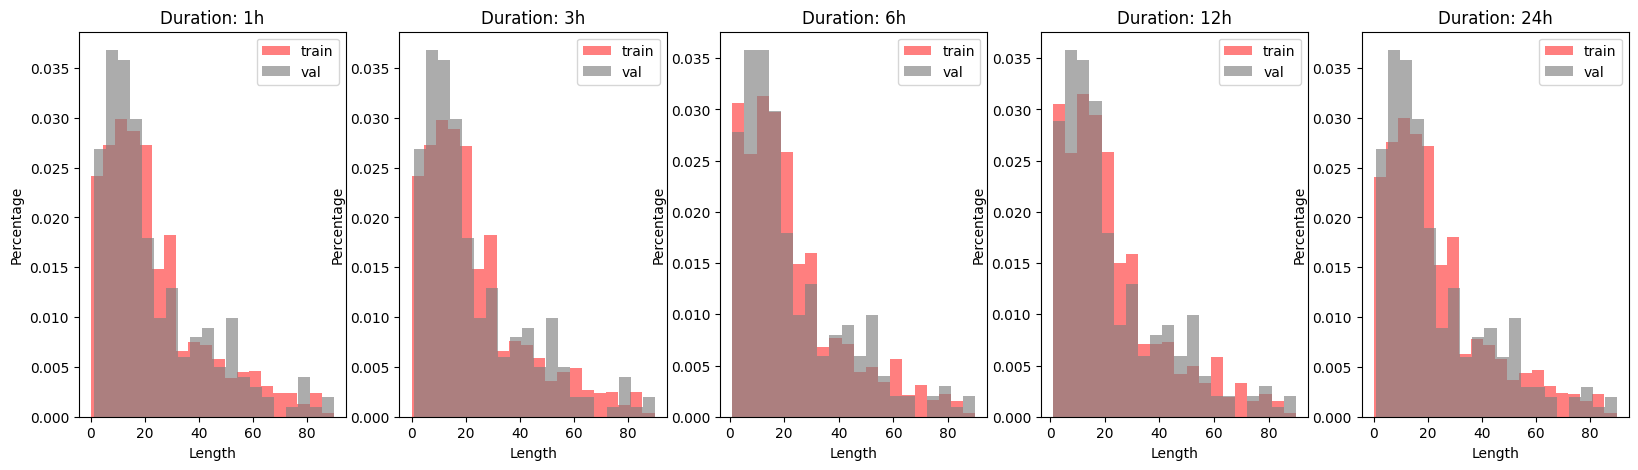

In [10]:
durations = [1, 3, 6, 12, 24]

def compute_timeseries_length(df, duration):
    lenghts = []
    for i in range(len(df)):
        series = df['AMS_'+str(duration)][i]
        if np.isnan(series).any():
            lenghts.append(0)
        else:
            lenghts.append(len(series))
    return lenghts

def plot_timeseries_length(df_train, df_val, durations):
    fig, axs = plt.subplots(1, len(durations), figsize=(20, 5))
    for i, duration in enumerate(durations):
        lenghts_train = compute_timeseries_length(df_train, duration)
        lenghts_val = compute_timeseries_length(df_val, duration)
        axs[i].set_ylabel('Percentage')
        axs[i].set_title('Duration: '+str(duration)+'h')
        axs[i].set_xlabel('Length')
        axs[i].hist(lenghts_train, bins=20, alpha=0.5, label='train', density=True, color='red')
        axs[i].hist(lenghts_val, bins=20, alpha=0.65, label='val', density=True, color='gray')
        axs[i].legend()
    plt.show()

plot_timeseries_length(train_df, val_df, durations)

### MAP distribution for training and validation

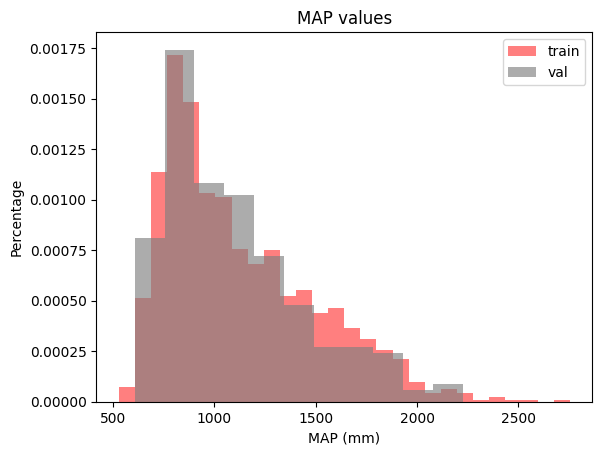

In [18]:
plt.hist(train_df['MAP(mm)'], bins='auto', alpha=0.5, label='train', density=True, color='red')
plt.hist(val_df['MAP(mm)'], bins='auto', alpha=0.65, label='val', density=True, color='gray')
plt.ylabel('Percentage')
plt.title('MAP values')
plt.xlabel('MAP (mm)')
plt.legend()
plt.show()